In [372]:
##Projeto de conclusão do curso de sistemas** -- Final project of Course
#**#Autor: Klemer Monteiro, 2020
#**Ferramenta para agrupar trechos textuais por meio da modelagem em tópicos - Modeling Topics focusing in the LDA algoritm**
#contact: klemermonteiro@ufrrj.br





In [373]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [374]:
#python 3 and python 2 #para puxar as bibliotecas que estejam disponíveis na versões. 
from __future__ import print_function 

In [476]:
# Importing modules 
import sys
import io 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import langdetect
import tqdm
import time 
%matplotlib inline

# Gensim
import gensim, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

<h2>**Reading** - Leitura</h2>
**Observações: Dentro de datasets também possui um outro dataset com 4 arquivos denso de conteúdo,mas, para fins de granularidade aumentamos para 89 capitulos**
**We have inside the dataset another database with 4 dense documents. At the moment, we use 89 charpters with document unity to choose another granularity.**

In [376]:
#Ler os dados aqui. #docs_gospels_todos_.csv  89 docs
##data = pd.read_csv('./datasets/docs_gospels_todos_4.csv', sep=';',encoding='utf-8') #to change tht documents.
data = pd.read_csv('./datasets/docs_gospels_todos.csv', sep=';',encoding='utf-8')
#Imprima as linhas com .head()
data.head()

,caps,text
0,Mateus 1,Registro da genealogia de Jesus Cristo filho d...
1,2,Depois que Jesus nasceu em Belém da Judéia nos...
2,3,Naqueles dias surgiu João Batista pregando no ...
3,4,Então Jesus foi levado pelo Espírito ao desert...
4,5,Vendo as multidões Jesus subiu ao monte e se a...


In [377]:
data.shape #linhas e colunas

(89, 2)

In [378]:
#Granularity
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   caps    89 non-null     object
 1   text    89 non-null     object
dtypes: object(2)
memory usage: 1.5+ KB


In [379]:
#data.describe().head(89)

In [380]:
#Removendo a coluna de capítulos, pois não precisamos das mesmas -Remove caps of dataframe 
data = data.drop('caps', axis=1) #df.drop('column_name', axis=1)
data.head()

,text
0,Registro da genealogia de Jesus Cristo filho d...
1,Depois que Jesus nasceu em Belém da Judéia nos...
2,Naqueles dias surgiu João Batista pregando no ...
3,Então Jesus foi levado pelo Espírito ao desert...
4,Vendo as multidões Jesus subiu ao monte e se a...


<h2>Cleanning</h2>

**Remove all ASCII and the majority ponctuations** 

In [381]:
# Remove punctuation tutorial 5 of Apendice
#https://www.youtube.com/watch?v=F_gYj6fcSl4&ab_channel=Ot%C3%A1vioMiranda
import unicodedata
import re
import string 

def clean_text_docs_round1(text):
    normalized= unicodedata.normalize('NFD', text)
    return normalized.encode('ascii','ignore').decode('utf8').casefold()  

round1 = lambda x: clean_text_docs_round1(x)


'''
def clean_text_docs_round1(text):
        text= text.lower()
        text= re.sub('[.*,\.!?´`^~]', ' ',text) #remover acentos 
        text= re.sub('[-|0:9]', ' ', text)
        text= re.sub(r"^\s+|\s+$", ' ', text)   
        text = re.sub('\r',' ', text) 
        text = re.sub('\n',' ', text) #remover linhas
        text= re.sub('[%s]' % re.escape(string.punctuation), ' ',text)
        text= re.sub('\s\w*\d\w*',' ',text)
        return text
 '''
''' 
def clean_text_docs_round1(str text) -> str:      #https://www.youtube.com/watch?v=F_gYj6fcSl4&ab_channel=Ot%C3%A1vioMiranda
    normalized= unicodedata.normalize('NFD',text)
    return normalized.encode('ascii','ignore').decode('utf8').casefold()
'''



" \ndef clean_text_docs_round1(str text) -> str:      #https://www.youtube.com/watch?v=F_gYj6fcSl4&ab_channel=Ot%C3%A1vioMiranda\n    normalized= unicodedata.normalize('NFD',text)\n    return normalized.encode('ascii','ignore').decode('utf8').casefold()\n"

In [382]:
#Atualizar documento com o texto atualizado fase 1
data_clean = pd.DataFrame(data.text.apply(round1))
data_clean.head()

,text
0,registro da genealogia de jesus cristo filho d...
1,depois que jesus nasceu em belem da judeia nos...
2,naqueles dias surgiu joao batista pregando no ...
3,entao jesus foi levado pelo espirito ao desert...
4,vendo as multidoes jesus subiu ao monte e se a...


In [383]:
# Apply a second round of cleaning
def clean_text_round2(text):
    '''Get rid of some additional punctuation and non-sensical text that was missed the first time around.'''
    #text = re.sub('[.*‘’“”]',' ', text)
    #text = re.sub('\r',' ', text)
    #text= re.sub(r"^\s+|\s+$",' ', text)
    #text = re.sub('\n',' ', text)
    text= re.sub('([.,-:\.!?^~)(´`^0-9])?','',text)
    return text

round2 = lambda x: clean_text_round2(x)

In [384]:
# Let's take a look at the updated text - Fazer um novo update dos textos sem algumas das pontuações prévias
data_clean = pd.DataFrame(data_clean.text.apply(round2))
data_clean.head()

,text
0,registro da genealogia de jesus cristo filho d...
1,depois que jesus nasceu em belem da judeia nos...
2,naqueles dias surgiu joao batista pregando no ...
3,entao jesus foi levado pelo espirito ao desert...
4,vendo as multidoes jesus subiu ao monte e se a...


In [385]:
#testa uma linha testar para ver se está sem puntuação - test a line to view the data without punctuation
#print(data_clean['text'][0])

In [386]:
#Remove Nulls- Remover Nulos
data_clean = data_clean.dropna().reset_index(drop=True)
print('Size Corpus: ',len(data_clean['text']))
data_clean['text']

Size Corpus:  89


0     registro da genealogia de jesus cristo filho d...
1     depois que jesus nasceu em belem da judeia nos...
2     naqueles dias surgiu joao batista pregando no ...
3     entao jesus foi levado pelo espirito ao desert...
4     vendo as multidoes jesus subiu ao monte e se a...
                            ...                        
84    depois de dizer isso jesus olhou para o ceu e ...
85    tendo terminado de orar jesus saiu com os seus...
86    entao pilatos mandou acoitar jesus  os soldado...
87    no primeiro dia da semana bem cedo estando ain...
88    depois disso jesus apareceu novamente aos seus...
Name: text, Length: 89, dtype: object

In [387]:
#Amazenar os dados em um formato pickle para ulilizado posteriormente --  To pickle
import pickle
data_clean.to_pickle('dados_limpos.pkl')



**Keeping Portuguese texts in documents**

In [388]:
from langdetect import detect
from langdetect import detect_langs
from tqdm import tqdm
from tqdm import tqdm_notebook

In [389]:
#detectar português
data_clean['lang'] = data_clean.text.map(detect)

In [390]:
data_clean.lang.value_counts()

pt    89
Name: lang, dtype: int64

In [391]:
data_clean = data_clean.loc[data_clean.lang=='pt']

<h1>NLP and Tokenization</h1>

**Importinhg libraries do use the Tokennization and other Nlp processing** - Importar as bibliotecas básicas para tokenization

In [393]:
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Klemer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

<h1>Stopwords</h1>

**Regrouping stop words**

In [565]:
# coding: utf8
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
#from string import punctuaction
#nltk.download('portuguese')
from __future__ import unicode_literals

#stopwords_verbs = ['say', 'get', 'go', 'know', 'may', 'need', 'like', 'make', 'see', 'want', 'come', 'take', 'use', 'would', 'can'

stopwords_other = (
"""
a
acerca
adeus
agora
ainda
alem
algo
algumas
alguns
alguem
ali
além
alem
ambas
ambos
ano
anos
antes
ao
aonde
aos
apenas
apoio
apontar
apos
aquela
aquelas
aquele
aqueles
aqui
aquilo
as
assim
aparecer
apareceram
apareceu
através
atraves
atrás
ate
ai
assentar
assentou
ais
arrepender
arrependeram
arrependerao
arrependeriam
acontecer
aconteceu
baixo
baixos
bastante
bastantes
bem
boa
boas
bom
bons
breve
cair
caiu
cairam
cairao
cada
caminho
catorze
cedo
cento
certamente
certeza
cima
cinco
coisa
coisas
com
como
comprido
conhecido
conselho
contra
contudo
corrente
cuja
cujas
cujo
cujos
custa
custar
custou
cresce
crescer
cresceu
creceram
cresceriam
crescerão
crer
creram
comecar
comecaram
comecariam
comecarao
ca
da
daquela
daquelas
daquele
daqueles
dar
dara
daras
das
de
debaixo
dela
delas
dele
deles
demais
dentro
depois
desde
desligado
dessa
dessas
desse
desses
desta
destas
deste
destes
deve
devem
devera
dez
dezanove
dezasseis
dezassete
dezoito
deixar
deixaram
deixou
dixarao
dia
diante
direita
dispoe
dispoem
diversa
diversas
diversos
diz
dizem
dizer
diziam
disse
disseram
dizendo
do
doi
dois
dos
doze
duas
durante
da
dao
duvida
dito
diria
duvidar
duvide
duvidas
e
ela
elas
ele
eles
em
embora
encontrar
encontraram
encontrariam
enquanto
entao
entre
era
eram
essa
essas
esse
esses
esta
estado
estando
estamos
estar
estara
estas
estava
estavam
este
estes
entregar
entregue
entregaram
esteja
estejam
estejamos
esteve
estive
estivemos
estiver
estivera
estiveram
estiverem
estivermos
estivesse
estivessem
estiveste
estivestes
estiveramos
estivessemos
estou
esta
estas
estavamos
estao
entrar
entraram
entrariam
entrarao
eu
exemplo
clamar
clamaram
falar 
falaram
falta
fara
favor
faz
fazeis
fazer
façam
faria
fizeram
façam
fazem
fazemos
fazer
fazes
fazia
faço
fez
fim
final
foi
fomos
for
fora
foram
forem
forma
formos
fosse
fossem
foste
fostes
fui
foramos
fossemos
geral
gerar
gerou
grande
grandes
grupo
ha
haja
hajam
hajamos
havemos
haver
haveria
havera
havia
haviam
hei
hoje
hora
horas
houve
houvemos
houver
houvera
houveram
houverei
houverem
houveremos
houveria
houveriam
houvermos
houvera
houverao
houveríamos
houvesse
houvessem
houveramos
houvessemos
hao
iniciar
inicio
ir
ira
isso
ista
iste
isto
ja
junto
juntou 
juntar
juntaram
lado
lados
lhe
lhes
ligado
local
localizar
logo
longe
lugar
la
lo
lar
lisar
maior
maiores
maioria
maiorias
mais
mal
maldar
mas
me
mediante
meio
menor
menos
meses
mesma
mesmas
mesmo
mesmos
meu
meus
mil
minha
minhas
momento
muito
muitos
maximo
mes
mim
mas
mais
morreu
morrer
na
nasceu
nascer
morreu
morrer
nada
nao
naquela
naquelas
naquele
naqueles
nas
nem
nenhuma
nenhum
nessa
nessas
nesse
nesses
nesta
nestas
neste
nestes
nele
no
noite
nome
nos
nossa
nossas
nosso
nossos
nova
novas
nove
novo
novos
num
numa
numas
nunca
novamente
nuns
nao
nivel
nos
numero
o
ordenar
ordenou
ordenaram
olhar
olhou
olharam
olhariam
obra
obrigada
obrigado
oitava
oitavo
oito
onde
ontem
onze
os
ou
outra
outras
outro
outros
ouviram 
ouvir
ouviria
ouviu
ouvindo
ouvindolhe
ouvistes
orar
oraram
para
pregar
pregando
pregaram
parece
parecer
parecendo
pareceram
parte
partir
paucas
pegar
pela
pelas
pelo
pelos
perante
per
perto
pessoas
pode
podem
poder
podera
podia
pois
poi
ponto
pontos
por
porque
por que
portanto
posicao
possivelmente
posso
possível
pouca
pouco
poucos
procurar
procuraram
prostrou-se
prostrouse
procuroulhe
todavia
primeira
primeiras
primeiro
primeiros
propios
proprio
propria
proxima
proximas
puderam
pode
poe
poem
quais
qual
qualquer
quando
quanto
quarta
quarto
quatro
que
quem
quer
quereis
querem
queremos
queres
quero
quinta
quinto
quinze
quais
relacao
relacionar 
respondeu
responder 
respostas
responderam
receber
receberam
receberiam
receberão
sabe
sabem
saber
saberam
sabendo
se
segunda
segundo
sei
seis
seja
sejam
sejamos
sem
sempre
sendo
ser
serei
serao
senao
serum
seguir
seguiriam
seguiram
seremos
seria
seriam
sera
sero
seriamos
sete
seu
seus
sexta
sexto
sim
sistema
sob
sobre
sois
somente
somos
sou
sua
suas
sao
setima
setimo
so
sair
sairam
saiu
tal
talvez
tambem
tanta
tantas
tanto
tarde
te
tem
temos
tempo
tendes
tenha
tenham
tenhamos
tenho
tens
tentar
tentaram
tente
tentei
tentado
tentar
ter
terceira
terceiro
terei
teremos
teria
teriam
tera
terao
tirou
tiraram
teriamos
teu
teus
teve
terminar
terminaram
terminariam
tinha
tinham
tipo
tive
tivemos
tiver
tivera
tiveram
tiverem
tivermos
tivesse
tivessem
tiveste
tivestes
tiveramos
tivessemos
toda
todas
todo
todos
trabalhar
trabalho
treze
tres
tu
tua
tuas
tudo
tao
tem
tinhamos
um
uma
umas
uns
usa
usar
vai
va
vao
vais
valor
veja
vem
vens
ver
viram
veriam
verao
viu
verdade
verdadeiro
vez
vezes
viagem
vindo
vinte
voce
voces
vos
vox
vossa
vossas
vosso
vossos
varios
vao
vem
zero
entao
eramos
es
pois
poi
por 
ninguem 
digo 
coisa
coisas
perguntou
perguntariam
perguntaram
perguntar
pergunta
perguntoulhe
acumular 
acumulou
acumularam
furtar 
furtou
enviou
enviar
si
deu
dar
igualar 
suportar
suportaram
suportariam
ficou
ficaram
aproximar
aproximou
aproximaram 
saindo
sairam
saiu
causa
sido
ante
comecou 
imediatamente
vendo
tendo 
deram
orou 
subiu
correu
mt
mc
jc
lc
lo
at
la
ma
disso
daquilo
depois
dizer 
isso
naquilo
nenhum
nenhuma
nasceu
nascer
nascido
chegou
acoitar
falando
voltando
dispensaramlhe
glorificar
glorifica""".split())

'''
def clean_stop_words(stopwords_other):
    normalized= unicodedata.normalize('NFD',stopwords_other)
    return normalized.encode('ascii','ignore').decode('utf8').casefold()
'''
#en_stop=stopwords.words('English')
pt_stop= stopwords.words('portuguese')
other_stop= stopwords_other 


#stopwords = set(stopwords.words('portuguese') + list(punctuation))
%time my_stopwords = pt_stop + other_stop    #+ en_stop 
#%time my_stopwords = stopwords + stopwords_other
print(my_stopwords[:200])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Klemer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Klemer\AppData\Roaming\nltk_data...


Wall time: 0 ns
['de', 'a', 'o', 'que', 'e', 'é', 'do', 'da', 'em', 'um', 'para', 'com', 'não', 'uma', 'os', 'no', 'se', 'na', 'por', 'mais', 'as', 'dos', 'como', 'mas', 'ao', 'ele', 'das', 'à', 'seu', 'sua', 'ou', 'quando', 'muito', 'nos', 'já', 'eu', 'também', 'só', 'pelo', 'pela', 'até', 'isso', 'ela', 'entre', 'depois', 'sem', 'mesmo', 'aos', 'seus', 'quem', 'nas', 'me', 'esse', 'eles', 'você', 'essa', 'num', 'nem', 'suas', 'meu', 'às', 'minha', 'numa', 'pelos', 'elas', 'qual', 'nós', 'lhe', 'deles', 'essas', 'esses', 'pelas', 'este', 'dele', 'tu', 'te', 'vocês', 'vos', 'lhes', 'meus', 'minhas', 'teu', 'tua', 'teus', 'tuas', 'nosso', 'nossa', 'nossos', 'nossas', 'dela', 'delas', 'esta', 'estes', 'estas', 'aquele', 'aquela', 'aqueles', 'aquelas', 'isto', 'aquilo', 'estou', 'está', 'estamos', 'estão', 'estive', 'esteve', 'estivemos', 'estiveram', 'estava', 'estávamos', 'estavam', 'estivera', 'estivéramos', 'esteja', 'estejamos', 'estejam', 'estivesse', 'estivéssemos', 'estivessem', '

[nltk_data]   Package stopwords is already up-to-date!


<h1>Exploratory Analysis</h1>

Wall time: 1min 29s


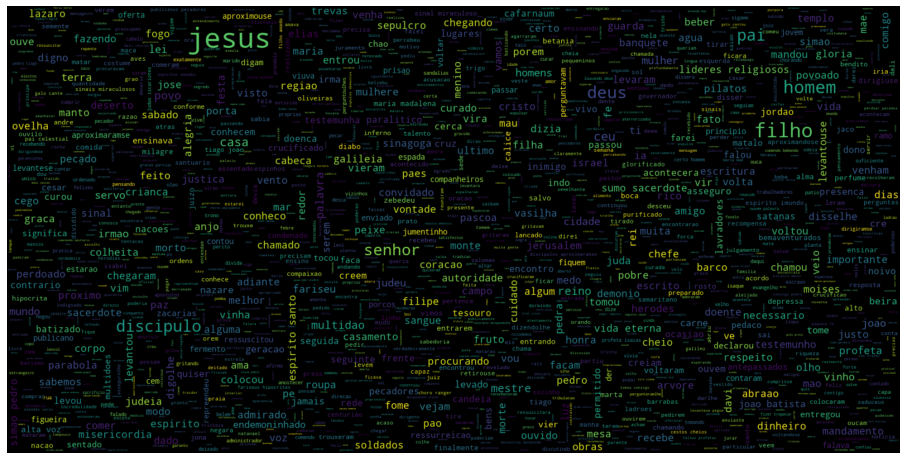

In [626]:
#Exploratory Analysis
# Import the wordcloud library

import time
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS


#Concatenar as palavras
data_words = []
data_words = " ".join(list(data_clean['text'].values)) #tutorial 1 

%time wordcloud= WordCloud(stopwords =my_stopwords, background_color="black", \
                     contour_width=3, contour_color="steelblue", \
                     max_words= 393000, \
                     random_state=42, \
                     width=1600, \
                     height=800,max_font_size=50).generate(data_words) # Criar uma WordCloud # lower max_font_size

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(16, 10)) #plt.figure(2, figsize=(16,6)) # figsize(15, 15/1.6180) #figsize=(16,9)
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");
wordcloud.to_file("WorldCloud_lda_gospels.png") #Salva quando tiver certeza que as imagens estão certas. 


#Gerar a WordCloud
 #for index, doc in enumerate(data_clean.columns):


# Visualizar as WorldCloud
# Mostrar a imagem final 
#import matplotlib.pyplot as plt

#plt.title("Nuvem de palavras dos Evangelhos", fontsize=40, color="red")
#fig, ax=plt.subplots(figsize=(16,6))
#ax.imshow(wordcloud, interpolation="bilinear")
#ax.set_axis_off()
#wordcloud.to_image();
#wordcloud.to_file("WorldCloud_lda_gospels.png") #Salva quando tiver certeza que as imagens estão certas.

In [624]:
print(len(data_words))

392386


In [568]:
#Tokens Sentences without Tokenization

In [569]:
#Documents of Propose

In [627]:
import nltk
import pickle
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
#extra_abbreviations = ['\n']
#sent_tokenizer=nltk.data.load('tokenizers/punkt/portuguese.pickle')
data_clean['sentences'] = data_clean.text.map(sent_tokenize)
data_clean['sentences']# Print the sentences of the Gospels and Charpers -

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Klemer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


0     [registro da genealogia de jesus cristo filho ...
1     [depois que jesus nasceu em belem da judeia no...
2     [naqueles dias surgiu joao batista pregando no...
3     [entao jesus foi levado pelo espirito ao deser...
4     [vendo as multidoes jesus subiu ao monte e se ...
                            ...                        
84    [depois de dizer isso jesus olhou para o ceu e...
85    [tendo terminado de orar jesus saiu com os seu...
86    [entao pilatos mandou acoitar jesus  os soldad...
87    [no primeiro dia da semana bem cedo estando ai...
88    [depois disso jesus apareceu novamente aos seu...
Name: sentences, Length: 89, dtype: object

In [628]:
%time data_clean['tokens_sentences'] = data_clean['sentences'].map(lambda sentences: [word_tokenize(sentence) for sentence in sentences])
data_clean['tokens_sentences']
#print(len(data_clean['tokens_sentences']))

Wall time: 1.75 s


0     [[registro, da, genealogia, de, jesus, cristo,...
1     [[depois, que, jesus, nasceu, em, belem, da, j...
2     [[naqueles, dias, surgiu, joao, batista, prega...
3     [[entao, jesus, foi, levado, pelo, espirito, a...
4     [[vendo, as, multidoes, jesus, subiu, ao, mont...
                            ...                        
84    [[depois, de, dizer, isso, jesus, olhou, para,...
85    [[tendo, terminado, de, orar, jesus, saiu, com...
86    [[entao, pilatos, mandou, acoitar, jesus, os, ...
87    [[no, primeiro, dia, da, semana, bem, cedo, es...
88    [[depois, disso, jesus, apareceu, novamente, a...
Name: tokens_sentences, Length: 89, dtype: object

In [629]:
#import itertools
#from itertools import chain # to flatten list of sentences of tokens into list of tokens

#data_clean['tokens_stopwords'] = data_clean['tokens_sentences'].map(lambda sentences: list(chain.from_iterable(sentences)))
#data_clean['tokens_stopwords'] = data_clean['tokens_stopwords'].map(lambda tokens: [token.lower() for token in tokens if token.isalpha() 
                                                               #and token.lower() not in my_stopwords and len(token)>1])

In [630]:
#print(data_clean['tokens_stopwords'])

**Lemmatizing with POS tagging - Lemmatização com pos taguiamento usando NLTK, uma função de ajuste e stopwords **
#https://stackoverflow.com/questions/15586721/wordnet-lemmatization-and-pos-tagging-in-python/15590384#15590384
#https://sites.google.com/site/linguacorpus/acdc/mac-morpho

In [632]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Klemer\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Klemer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [633]:
%time data_clean['POS_tokens'] = data_clean['tokens_sentences'].map(lambda tokens_sentences: [pos_tag(tokens) for tokens in tokens_sentences])
print(data_clean['POS_tokens'])
#%time data_clean['POS_tokens'] = data_clean['tokens_stopwords'].map(lambda tokens_stopwords: [pos_tag(tokens) for tokens in tokens_stopwords])
#print(data_clean['POS_tokens'])

Wall time: 32.2 s
0     [[(registro, NN), (da, NN), (genealogia, NN), ...
1     [[(depois, NN), (que, NN), (jesus, NN), (nasce...
2     [[(naqueles, NNS), (dias, VBP), (surgiu, JJ), ...
3     [[(entao, JJ), (jesus, NN), (foi, NN), (levado...
4     [[(vendo, NN), (as, IN), (multidoes, NNS), (je...
                            ...                        
84    [[(depois, NN), (de, IN), (dizer, FW), (isso, ...
85    [[(tendo, JJ), (terminado, NN), (de, IN), (ora...
86    [[(entao, NN), (pilatos, NN), (mandou, NN), (a...
87    [[(no, DT), (primeiro, NN), (dia, VBZ), (da, J...
88    [[(depois, NN), (disso, NN), (jesus, NN), (apa...
Name: POS_tokens, Length: 89, dtype: object


In [634]:
# Inspired from https://stackoverflow.com/a/15590384
#https://stackoverflow.com/questions/15586721/wordnet-lemmatization-and-pos-tagging-in-python
''' 
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].lower()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)
''' 
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'): #return adjetico
        return wordnet.ADJ   
    elif treebank_tag.startswith('V'): #return verbo
        return wordnet.VERB
    elif treebank_tag.startswith('R'): #return substantivo
        return wordnet.ADV
    elif treebank_tag.startswith('N'): #return Adverbio
        return wordnet.NOUN
    else:
        return '' #Return Noun for default

from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [635]:
# Lemmatizing each word with its POS tag, in each sentence - Lemmatizando cada palavra para cada frase #tokens_POS coloquei POS_tokens
data_clean['tokens_sentences_lemmatized'] = data_clean['POS_tokens'].map(
    lambda list_tokens_POS: [
    [
      lemmatizer.lemmatize(el[0], get_wordnet_pos(el[1])) 
      if get_wordnet_pos(el[1]) != ''  else el[0] for el in tokens_POS
    ] 
    for tokens_POS in list_tokens_POS
     ]  
    )

In [636]:
%time data_clean['tokens_sentences_lemmatized']

Wall time: 1e+03 µs


0     [[registro, da, genealogia, de, jesus, cristo,...
1     [[depois, que, jesus, nasceu, em, belem, da, j...
2     [[naqueles, dias, surgiu, joao, batista, prega...
3     [[entao, jesus, foi, levado, pelo, espirito, a...
4     [[vendo, as, multidoes, jesus, subiu, ao, mont...
                            ...                        
84    [[depois, de, dizer, isso, jesus, olhou, para,...
85    [[tendo, terminado, de, orar, jesus, saiu, com...
86    [[entao, pilatos, mandou, acoitar, jesus, os, ...
87    [[no, primeiro, dia, da, semana, bem, cedo, es...
88    [[depois, disso, jesus, apareceu, novamente, a...
Name: tokens_sentences_lemmatized, Length: 89, dtype: object

In [637]:
#https://stackoverflow.com/questions/59093618/how-to-extract-specific-lemma-or-pos-tag-using-spacy
#https://stackoverflow.com/questions/34102420/pos-tagging-using-spacy?rq=1
'''import spacy
import pt_core_news_sm
nlp = pt_core_news_sm.load()


#stopwords = ["here", "are", "some", "stopwords"]

def tokenizeTexte(token):
    doc = nlp(token)
    lemmas = []
    for tok in tokens:
        if tok.pos_ in ("VERB", "ADJ", "ADV","NOUN"):
            lemmas.append((tok.lemma_.lower(), tok.tag_, tok.pos_))
    tokens = [(lemma, tag, pos) for (lemma, tag, pos) in lemmas if lemma not in my_stopwords]
    return tokens

#%time round3 = lambda x: tokenizeTexte(x)
''' 

'import spacy\nimport pt_core_news_sm\nnlp = pt_core_news_sm.load()\n\n\n#stopwords = ["here", "are", "some", "stopwords"]\n\ndef tokenizeTexte(token):\n    doc = nlp(token)\n    lemmas = []\n    for tok in tokens:\n        if tok.pos_ in ("VERB", "ADJ", "ADV","NOUN"):\n            lemmas.append((tok.lemma_.lower(), tok.tag_, tok.pos_))\n    tokens = [(lemma, tag, pos) for (lemma, tag, pos) in lemmas if lemma not in my_stopwords]\n    return tokens\n\n#%time round3 = lambda x: tokenizeTexte(x)\n'

In [638]:
#%time data_clean['tokens_lemmatizados'] = data_clean['tokens_sentences'].map(lambda tokens: [tokenizeTexte(token) for token in tokens])
#data_clean['tokens_lemmatizados']

In [639]:
#%time data_clean['tokens_lemmatizados'] = data_clean['text'].apply(round3)


#data_clean["tokens"] = data_clean['tokens_sentences'].map(lambda token_sentences: list(chain.from_iterable(sentences)))
#data_clean["tokens"]= data_clean['tokens'].map(lambda tokens: [round(tokens_sentences) for token in tokens_sentences if token.isalpha() 
                                                              #and len(token)>2])

In [640]:
#Iterar e GENERATE TOKENS

In [641]:
import itertools
from itertools import chain # to flatten list of sentences of tokens into list of tokens
data_clean['tokens'] = data_clean['tokens_sentences_lemmatized'].map(lambda sentences: list(chain.from_iterable(sentences)))
data_clean['tokens'] = data_clean['tokens'].map(lambda tokens: [token.lower() for token in tokens if token.isalpha() 
                                                                and token.lower() not in my_stopwords and len(token)>2])

In [642]:
%time data_clean['tokens'] #TOKENS

Wall time: 999 µs


0     [registro, genealogia, jesus, cristo, filho, d...
1     [jesus, belem, judeia, dias, rei, herodes, mag...
2     [dias, surgiu, joao, batista, deserto, judeia,...
3     [jesus, levado, espirito, deserto, diabo, jeju...
4     [multidoes, jesus, monte, discipulos, aproxima...
                            ...                        
84    [jesus, ceu, pai, filho, filho, glorifique, au...
85    [terminado, jesus, discipulos, atravessou, val...
86    [pilatos, mandou, jesus, soldados, teceram, co...
87    [semana, escuro, maria, madalena, sepulcro, pe...
88    [jesus, discipulos, margem, mar, tiberiades, s...
Name: tokens, Length: 89, dtype: object

In [643]:
#print(data_clean['tokens'][87]) #Verifica um TOKEN ALEATORIO

In [644]:
''' 
https://stackoverflow.com/questions/34102420/pos-tagging-using-spacy?rq=1

import spacy
nlp = spacy.load("pt_core_news_sm")

#stopwords= STOP_WORDS

textos = data_clean['text'] # ou usar tokens_sentences
doc = list(nlp.pipe(text))

nlp = spacy.load("pt", disable=['parser', 'tagger', 'ner'])
#stops = stopwords.words("portuguese")

def normalize(comment, lowercase, remove_stopwords):
    if lowercase:
        comment = comment.lower()
    comment = nlp(comment)
    lemmatized = list()
    for word in comment:
        lemma = word.lemma_.strip()
        if lemma:
            if not remove_stopwords or (remove_stopwords and lemma not in my_stopwords):
                lemmatized.append(lemma)
                return " ".join(lemmatized)

 data_df['text_after_clean'] = data_clean['text'].apply(normalize, lowercase=True, remove_stopwords=True)
data_df['text_after_clean'].head()

'''


' \nhttps://stackoverflow.com/questions/34102420/pos-tagging-using-spacy?rq=1\n\nimport spacy\nnlp = spacy.load("pt_core_news_sm")\n\n#stopwords= STOP_WORDS\n\ntextos = data_clean[\'text\'] # ou usar tokens_sentences\ndoc = list(nlp.pipe(text))\n\nnlp = spacy.load("pt", disable=[\'parser\', \'tagger\', \'ner\'])\n#stops = stopwords.words("portuguese")\n\ndef normalize(comment, lowercase, remove_stopwords):\n    if lowercase:\n        comment = comment.lower()\n    comment = nlp(comment)\n    lemmatized = list()\n    for word in comment:\n        lemma = word.lemma_.strip()\n        if lemma:\n            if not remove_stopwords or (remove_stopwords and lemma not in my_stopwords):\n                lemmatized.append(lemma)\n                return " ".join(lemmatized)\n\n data_df[\'text_after_clean\'] = data_clean[\'text\'].apply(normalize, lowercase=True, remove_stopwords=True)\ndata_df[\'text_after_clean\'].head()\n\n'

In [645]:
'''
#Frequencia uma funcionava e não funcinaou mais.
import nltk
from nltk import word_tokenize
from nltk.probability import FreqDist
from collections import Counter
import itertools
from nltk import FreqDist
from nltk.util import ngrams




''' 


''' 

from pprint import pprint
w= []
w = data_clean['tokens']
fdist = FreqDist(w)
for words in w:
    print(str(i)+','+words+": "+ fdist[words][0:30] % len(fdist))
    print(words, fdist[30])
  

tokens_freq = [
    
data_clean['tokens'].tolist()
#print(tokens_freq)
#tokens= data_clean['tokens'].dropna(inplace=True)

#tokens = 0

#tokens = tokens_freq.apply(word_tokenize)
fdist = nltk.FreqDist(tokens_freq)
for words in fdist:
    fdist[words.lower()]+= 1]
print(words,fdist[words])
 
 

freqs = data_clean['tokens'].tolist().values() #this is my

fdist = FreqDist()
for word in word_tokenize(freqs):
        fdist[word.lower()] += 1
        print(fdist[word])



from pprint import pprint
w= []
w = data_clean['tokens']
fdist = FreqDist(w)
for words in list(fdist.keys()):
    print(str(i)+','+words+": "+ fdist[words][0:30] % len(fdist))
    print(words, fdist[30])


freq = data_clean.tokens.str.split().apply(lambda x: Counter(x))
pprint(freq)

print('Palavra que mais aparece é: ',fdist.max(), fdist[words])
'''

''' 
import nltk
import itertools
from nltk.probability import FreqDist
texts = data_clean['text']
texts = [nltk.word_tokenize(text) for text in texts ]
# collapse into a single list
tokens_fd = list(itertools.chain(*texts))

FD =FreqDist(tokens_fd)
FD
'''



'''
def most_common_words_list (x):
    word_count_tups = nltk.FreqDist(x['tokens']).most_common(x)
    return [word for word, count in word_count_tups]

data_clean ['freq30'] = data_clean.tokens.apply(lambda x: nltk.FreqDist(x['tokens']).most_common(30),  result_type='reduce', axis=1)
data_clean['freq30']
''' 

"\ndef most_common_words_list (x):\n    word_count_tups = nltk.FreqDist(x['tokens']).most_common(x)\n    return [word for word, count in word_count_tups]\n\ndata_clean ['freq30'] = data_clean.tokens.apply(lambda x: nltk.FreqDist(x['tokens']).most_common(30),  result_type='reduce', axis=1)\ndata_clean['freq30']\n"

<h1>LDA</h1>

<h2>Data Preparation</h2>

**Prepare text for LDA Analysis**

C:\Users\Klemer\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['prostrou'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
C:\Users\Klemer\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


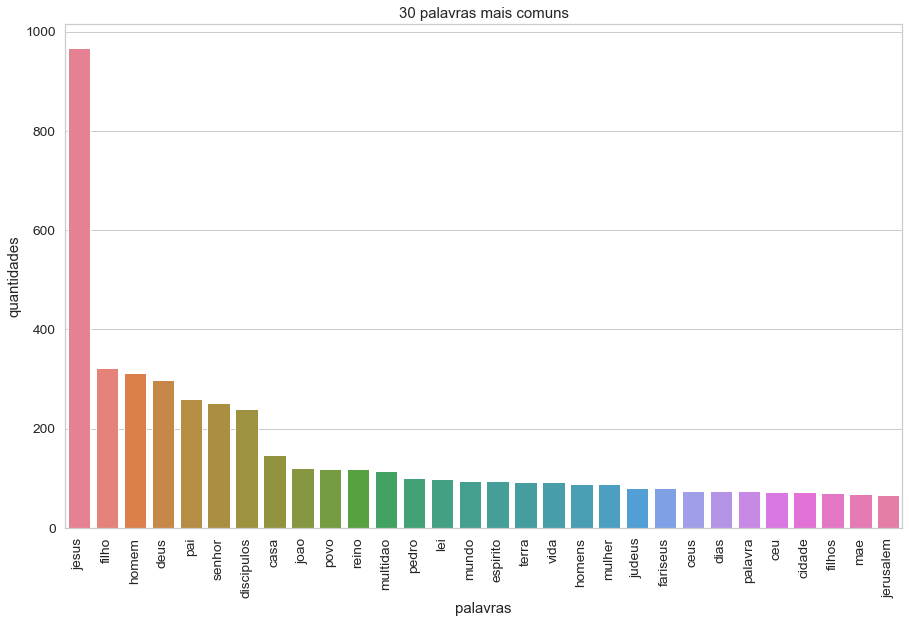

<Figure size 432x288 with 0 Axes>

In [646]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline


# Helper function
def plot_30_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:30]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='30 palavras mais comuns')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('palavras')
    plt.ylabel('quantidades')
    plt.show()
    plt.savefig('30_palavras_mais_comuns_evangelhos.png', format='png')


#Adicionando novas Stop-Words
count_vectorizer= CountVectorizer(stop_words = my_stopwords,lowercase=True)

#Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(data_clean['text'])

# Visualize the 30 most common words
plot_30_most_common_words(count_data, count_vectorizer) 


**Prepare bi-grams and tri-grams** -- Antes de criar um dicionário das palavras criar uma forma de encontrar bigramas, e trigramas, palavras com mais de dois ou três termos. 


# Gerar modelos com Gensim - Generate models Gensim

In [647]:
# Gensim
#import gensim, spacy, logging, warnings
import gensim
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.ldamodel import LdaModel
from gensim import corpora, models, similarities, downloader

from gensim.corpora.dictionary import Dictionary
from gensim.test.utils import get_tmpfile

from gensim import models
from gensim.models import Phrases


<h2>**Prepare objects for LDA gensim implementation** -- Preparar objetos de entrada ao modelo, agora com os tokens gerados, organizar um conjunto de palavras em um Dicionário.</h2>

In [648]:
tokens = data_clean['tokens']
bigram_model = Phrases(tokens)
trigram_model = Phrases(bigram_model[tokens], min_count=3)
tokens = list(trigram_model[bigram_model[tokens]])

# Create a dictionary representation of the documents.

# Filter out words that occur less than N documents, or more than 90% of the documents.
dictionary_LDA = corpora.Dictionary(tokens)
#dictionary_LDA.filter_extremes(no_below=1,no_above=0.95,keep_n=200000) 
#dictionary_LDA.filter_extremes(no_below=1,no_above=1.0,keep_n=200000) #no_above= 0.9 

# Bag-of-words representation of the documents.
corpus = [dictionary_LDA.doc2bow(text) for text in tokens]

#Determinado o tamanho dos documentos e do dicionário de palavras. 
print('Number of unique tokens: %d' % len(dictionary_LDA))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 6011
Number of documents: 89


In [649]:
#print(corpus[86])

In [650]:
#https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html#sphx-glr-auto-examples-tutorials-run-lda-py
#https://rare-technologies.com/what-is-topic-coherence/

#Add bigrams and trigrams to docs (only ones that appear 30 times or more).
#bigram = Phrases(data_clean['text'].head(4).tolist(), min_count=30)
#for idx in range(len(words)):
#    for token_i in bigram[w[idx]]:
#        if '_' in token_i:
             #Token is a bigram, add to document.
#                words[idx].append(token_i)



#tokens = pd.Series([tokens]).tolist()

#print(tokens[0][:200000])

<h2>Creating a transformation</h2>

**The transformations are standard Python objects, typically initialized by means of a training corpus**

In [651]:
from gensim import models

tfidf = models.TfidfModel(corpus)# step 1 -- initialize a model
corpus_tfidf = tfidf[corpus]

**Transforming vectors**

In [652]:
#Imprima o corpus da TF-IDF 
#for doc in corpus_tfidf: 
#    print(doc)


**In this particular case, we are transforming the same corpus that we used for training, but this is only incidental. Once the transformation model has been initialized, it can be used on any vectors (provided they come from the same vector space, of course), even if they were not used in the training corpus at all. This is achieved by a process called folding-in for LSA, by topic inference for LDA, etc.**

Font:
https://radimrehurek.com/gensim/auto_examples/core/run_topics_and_transformations.html#sphx-glr-auto-examples-core-run-topics-and-transformations-py

In [653]:

#Transformations can also be serialized, one on top of another, in a sort of chain
lsi_model = models.LsiModel(corpus_tfidf, id2word=dictionary_LDA, num_topics=10, chunksize=89, decay=1.0, distributed=False, onepass=True, power_iters=5)  # initialize an LSI transformation
corpus_lsi = lsi_model[corpus_tfidf]        #create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi
tmp_fname = get_tmpfile("lsi.model")      
lsi_model.save(tmp_fname)  # save model
#loaded_model = LsiModel.load(tmp_fname)  # load model

In [654]:
top_topics_lsi = lda_model.top_topics(corpus_lsi) #, num_words=25)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
#avg_topic_coherence = sum([t[1] for t in top_topics]) /num_topics
#print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
#pprint(top_topics)

for i,top_topics_lsi in lsi_model.show_topics(formatted=True, num_topics=num_topics, num_words=20):
    pprint(str(i)+": "+ top_topics_lsi)
    print()


#lsi_model.print_topics(10)

('0: 0.120*"pilatos" + 0.103*"joao" + 0.099*"filho" + 0.093*"judeus" + '
 '0.087*"pedro" + 0.084*"multidao" + 0.084*"pai" + 0.082*"pao" + 0.081*"barco" '
 '+ 0.081*"mundo" + 0.079*"sepulcro" + 0.073*"herodes" + 0.071*"discipulos" + '
 '0.070*"povo" + 0.069*"homem" + 0.064*"filho_homem" + 0.064*"mulher" + '
 '0.064*"casa" + 0.064*"senhor" + 0.063*"sabado"')

('1: 0.486*"pilatos" + 0.179*"sepulcro" + 0.141*"rei_judeus" + '
 '0.139*"barrabas" + 0.107*"soldados" + 0.106*"jose" + 0.103*"crucificao" + '
 '0.097*"chefes_sacerdotes" + 0.091*"sumo_sacerdote" + 0.086*"judeus" + '
 '0.082*"maria_madalena" + 0.073*"crucificado" + 0.070*"corpo" + 0.070*"vara" '
 '+ 0.069*"guardas" + 0.069*"crucificaram" + 0.067*"cruz" + 0.066*"governador" '
 '+ 0.064*"chefes_sacerdotes_lideres_religiosos" + 0.064*"pascoa"')

('2: 0.162*"barco" + -0.131*"lavradores" + 0.110*"herodes" + '
 '0.104*"paralitico" + -0.099*"cesar" + -0.086*"mundo" + 0.081*"pilatos" + '
 '-0.080*"jumentinho" + 0.076*"redes" + -0.075*"lazar

In [655]:
# both bow->tfidf and tfidf->lsi transformations are actually executed here, on the fly
documents= data_clean['text']
for doc, as_text in zip(corpus_lsi, documents):
            print(doc, as_text)

[(0, 0.09557966843118534), (1, 0.031043482914089697), (2, -0.048071717603185564), (3, -0.0844956017489103), (4, 0.08170181697702483), (5, -0.01907411310304168), (6, 0.010072183348190282), (7, -0.07301400172187872), (8, 0.05513445671464723), (9, -0.006750287732878925)] registro da genealogia de jesus cristo filho de davi filho de abraao  abraao gerou isaque  isaque gerou jaco jaco gerou juda e seus irmaos  juda gerou perez e zera cuja mae foi tamar perez gerou esrom esrom gerou arao  arao gerou aminadabe aminadabe gerou naassom naassom gerou salmom  salmom gerou boaz cuja mae foi raabe boaz gerou obede cuja mae foi rute obede gerou jesse  e jesse gerou o rei davi davi gerou salomao cuja mae tinha sido mulher de urias  salomao gerou roboao roboao gerou abias abias gerou asa  asa gerou josafa josafa gerou jorao jorao gerou uzias  uzias gerou jotao jotao gerou acaz acaz gerou ezequias  ezequias gerou manasses manasses gerou amom amom gerou josias  e josias gerou jeconiasa e seus irmaos no 

<h1>Running LDA</h1>      

<h3>**Number of Topics and After will choose the number of Words to each topics -- Escolha dos Parâmetros do modelo **</h3>

In [675]:

#Model 1
#the [distribution of the] number of words per topic is handled by eta
#the [distribution of the] number of topics per document is handled by alpha
# Train LDA model.
import time
from gensim.models import LdaModel

#Set training parameters.
num_topics = 30                          #number of topics
chunksize = 89                           #Documents control
passes = 5                               #epochs
iterations = 5                          #iterations between topics and docs
minimum_probability= 0.3              
minimum_phi_value= 0.3
per_word_topics = True
decay = 0.5         #Search some 
eval_every = -1  # Don't evaluate model perplexity, takes too much time.


%time
#np.random.seed(123456)         # Make a index to word dictionary.
temp = dictionary_LDA[0]  # This is only to "load" the dictionary.
id2word = dictionary_LDA.id2token
lda_model= models.LdaModel(corpus=corpus, \
                id2word=id2word, \
                alpha=[0.01]*num_topics, \
                eta=[0.001]*(len(dictionary_LDA)), \
                #iterations=iterations, \
                num_topics=num_topics, \
                decay = decay, \
                passes=passes, \
                #minimum_probability= minimum_probability, \
                #minimum_phi_value= minimum_phi_value, \
                #per_word_topics =  per_word_topics, \
                eval_every=eval_every)


Wall time: 999 µs


In [677]:
#Model 2
#the [distribution of the] number of words per topic is handled by eta
#the [distribution of the] number of topics per document is handled by alpha

import time
from gensim.models import LdaModel

#Set training parameters.
num_topics = 10                     #number of topics (priority choose)
chunksize = 89                      #Dependend of model chunksize growth the aceleration of modeling
passes = 5                          #epochs
alpha =0.1                           #hyperparameters  alpha is usedd to generate a matrix probabilistc of words
eta = 0.1                            # #hyperparameters  alpha is usedd to generate a matrix probabilistc of topics.
iterations = 5                     #iterations between topics and docs
minimum_probability= 0.3            #probabilidade minima dos topicos serem coerentes (opcional)
minimum_phi_value= 0.3              #IF per_word_topics for True, this respresents a litle limit of probabilisct terms
per_word_topics = True              #generate a list of to words and  correlations 
decay = 0.5                   #peso percentual de um lambda previo para termos esquecidos enquanto o documento é examinado.
eval_every=1              #Don't evaluate model perplexity, takes too much time -- Não verifica a perplexidade, fiz separadamente

#np.random.seed(123456)              #Random aleatoroy number of iterations -  
%time lda_model_2 = LdaModel(corpus, num_topics=num_topics, \
                          id2word=dictionary_LDA, \
                          passes=passes, \
                          alpha=alpha, \
                          eta=eta, \
                          decay = decay, eval_every=eval_every)
                          
                            #minimum_probability= minimum_probability, \ Optional sets I will pass in the work
                          #minimum_phi_value= minimum_phi_value, \
                           #per_word_topics=per_word_topics, \
                            


Wall time: 11.9 s


In [676]:
#Model 3
#the [distribution of the] number of words per topic is handled by eta
#the [distribution of the] number of topics per document is handled by alpha

import time
from gensim.models import LdaModel

#Set training parameters.
num_topics = 8                     #number of topics (priority choose)
chunksize = 89                      #Dependend of model chunksize growth the aceleration of modeling
passes = 5                          #epochs
alpha=0.1                         #hyperparameters  alpha is usedd to generate a matrix probabilistc of words
eta= 0.1                             # #hyperparameters  alpha is usedd to generate a matrix probabilistc of topics.
iterations = 5                     #iterations between topics and docs
minimum_probability= 0.3            #probabilidade minima dos topicos serem coerentes (opcional)
minimum_phi_value= 0.3              #IF per_word_topics for True, this respresents a litle limit of probabilisct terms
per_word_topics = True              #generate a list of to words and  correlations 
decay = 0.5                        #peso percentual de um lambda previo para termos esquecidos enquanto o documento é examinado.
eval_every=1            # Some autors talk about update or perplexity, the rehurek talks about update documents. 

np.random.seed(123456)              #Random aleatoroy number of iterations -  
%time lda_model_3 = LdaModel(corpus, num_topics=num_topics, \
                          id2word=dictionary_LDA, \
                          passes=passes, \
                          alpha=alpha, \
                          eta=eta, \
                          decay = decay, eval_every=eval_every) 
                          #minimum_probability= minimum_probability, \
                          #minimum_phi_value= minimum_phi_value, \
                          #per_word_topics=per_word_topics,\

Wall time: 10.1 s


In [669]:
# Computar a perplexidade do modelo (quanto menor, melhor) -- USe ro refine the model, if necessary
print('\nPerplexidade: ', lda_model.log_perplexity(corpus))

# Computar a perplexidade do modelo (quanto menor, melhor)
print('\nPerplexidade 2: ', lda_model_2.log_perplexity(corpus))

# Computar a perplexidade do modelo (quanto menor, melhor)
print('\nPerplexidade 3: ', lda_model_3.log_perplexity(corpus))


Perplexidade:  -13.616923485513452

Perplexidade 2:  -8.150848129772584

Perplexidade 3:  -8.152077426869905


In [670]:
# Computar o Score de Coerência -- Computing score of coherence -Future Works
import time

coherence_model_lda = CoherenceModel(model=lda_model, texts=tokens, dictionary=dictionary_LDA, coherence='c_v')
%time coherence_lda = coherence_model_lda.get_coherence()
print('\nScore de Coerência: ', coherence_lda)
 
coherence_model_lda_2 = CoherenceModel(model=lda_model_2, texts=tokens, dictionary=dictionary_LDA, coherence='c_v')
%time coherence_lda = coherence_model_lda.get_coherence()
print('\nScore de Coerência 2: ', coherence_lda)

coherence_model_lda_2 = CoherenceModel(model=lda_model_3, texts=tokens, dictionary=dictionary_LDA, coherence='c_v')
%time coherence_lda = coherence_model_lda.get_coherence()
print('\nScore de Coerência 2: ', coherence_lda)


Wall time: 52.9 s

Score de Coerência:  0.33055363784967723
Wall time: 12.6 s

Score de Coerência 2:  0.33055363784967723
Wall time: 16.8 s

Score de Coerência 2:  0.33055363784967723


<h1>Visualization of Topics with pyLDAvis</h1>

In [678]:
#The vizualizations will helps to chosse the best topics to chosse to anysi the model
#This Step is optional
%matplotlib inline
import pyLDAvis
import pyLDAvis.gensim
%time vis = pyLDAvis.gensim.prepare(topic_model=lda_model_2, corpus=corpus, dictionary=dictionary_LDA)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

Wall time: 42.8 s


In [679]:
#The vizualizations will helps to chosse the best topics to chosse to anysi the model
#This Step is optional
%matplotlib inline
import pyLDAvis
import pyLDAvis.gensim
%time vis = pyLDAvis.gensim.prepare(topic_model=lda_model_3, corpus=corpus, dictionary=dictionary_LDA)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

Wall time: 5.99 s


<h1>Quick exploration of LDA results</h1>

**Looking at topics**

In [661]:
top_topics = lda_model.top_topics(corpus) #, num_words=25)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
#avg_topic_coherence = sum([t[1] for t in top_topics]) /num_topics
#print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
#pprint(top_topics)

for i,top_topics in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=20):
    pprint(str(i)+": "+ top_topics)
    print()

('27: 0.028*"jesus" + 0.012*"discipulos" + 0.009*"homem" + 0.006*"deus" + '
 '0.006*"senhor" + 0.005*"pai" + 0.004*"ceu" + 0.004*"servo" + '
 '0.004*"reino_ceus" + 0.004*"mao" + 0.004*"pao" + 0.004*"homens" + '
 '0.004*"sumo_sacerdote" + 0.004*"coracao" + 0.004*"pedro" + 0.003*"casa" + '
 '0.003*"multidao" + 0.003*"povo" + 0.003*"irmao" + 0.003*"cidade"')

('22: 0.057*"homem" + 0.031*"jesus" + 0.025*"cego" + 0.022*"senhor" + '
 '0.020*"olhos" + 0.017*"deus" + 0.015*"pais" + 0.015*"sabemos" + '
 '0.013*"fariseus" + 0.010*"terra_saliva" + 0.010*"cegos" + 0.010*"discipulos" '
 '+ 0.009*"filho" + 0.009*"casa" + 0.008*"mundo" + 0.008*"pecador" + '
 '0.008*"abriu_olhos" + 0.008*"vejo" + 0.007*"marta" + 0.007*"ouvidos"')

('10: 0.029*"filho_homem" + 0.021*"senhor" + 0.018*"dias" + 0.016*"servo" + '
 '0.015*"campo" + 0.015*"estarao" + 0.015*"vinda" + 0.015*"casa" + 0.015*"noe" '
 '+ 0.015*"deixada" + 0.013*"vira" + 0.012*"ceu" + 0.011*"diluvio" + '
 '0.011*"comendo_bebendo" + 0.010*"disser" + 

In [662]:
top_topics_2 = lda_model_2.top_topics(corpus) #, num_words=20)

avg_topic_coherence_2 = sum([t[1] for t in top_topics_2]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence_2)

for i,top_topics in lda_model_2.show_topics(formatted=True, num_topics=num_topics, num_words=20):
    pprint(str(i)+": "+ top_topics)
    print()

Average topic coherence: -2.1526.
('3: 0.031*"filho" + 0.025*"jesus" + 0.011*"deus" + 0.008*"discipulos" + '
 '0.008*"pao" + 0.008*"povo" + 0.007*"senhor" + 0.006*"multidao" + '
 '0.005*"filhos" + 0.005*"pai" + 0.005*"ceu" + 0.005*"parabola" + '
 '0.004*"palavra" + 0.004*"lavradores" + 0.004*"vinha" + 0.004*"joao" + '
 '0.003*"barco" + 0.003*"cesar" + 0.003*"comer" + 0.003*"vida"')

('6: 0.054*"jesus" + 0.014*"discipulos" + 0.009*"homem" + 0.007*"joao" + '
 '0.007*"deus" + 0.007*"multidao" + 0.006*"casa" + 0.006*"senhor" + '
 '0.006*"pedro" + 0.004*"povo" + 0.004*"mao" + 0.004*"barco" + 0.004*"filho" + '
 '0.004*"filho_homem" + 0.004*"pai" + 0.003*"espirito" + 0.003*"homens" + '
 '0.003*"cidade" + 0.003*"mestre" + 0.003*"simao"')

('0: 0.029*"jesus" + 0.011*"homem" + 0.009*"deus" + 0.009*"discipulos" + '
 '0.007*"senhor" + 0.005*"homens" + 0.004*"coracao" + 0.004*"jerusalem" + '
 '0.004*"multidao" + 0.004*"casa" + 0.004*"mao" + 0.004*"pai" + 0.004*"cidade" '
 '+ 0.004*"filhos" + 0.003*

In [701]:
top_topics_3 = lda_model_3.top_topics(corpus) #, num_words=20)

avg_topic_coherence_3 = sum([t[1] for t in top_topics_2]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence_2)

for i,top_topics in lda_model_3.show_topics(formatted=True, num_topics=num_topics, num_words=20):
    pprint(str(i)+": "+ top_topics)
    print()

Average topic coherence: -2.1526.
('0: 0.034*"jesus" + 0.012*"deus" + 0.010*"homem" + 0.010*"discipulos" + '
 '0.009*"senhor" + 0.006*"cidade" + 0.005*"mulher" + 0.005*"homens" + '
 '0.005*"filho" + 0.005*"pai" + 0.005*"jerusalem" + 0.004*"multidao" + '
 '0.004*"coracao" + 0.004*"agua" + 0.004*"mao" + 0.004*"galileia" + '
 '0.004*"casa" + 0.003*"povo" + 0.003*"mestre" + 0.003*"cristo"')

('1: 0.044*"jesus" + 0.014*"pilatos" + 0.009*"homem" + 0.007*"pai" + '
 '0.006*"judeus" + 0.006*"povo" + 0.006*"deus" + 0.005*"jerusalem" + '
 '0.005*"multidao" + 0.004*"sabado" + 0.004*"senhor" + 0.004*"chamado" + '
 '0.004*"rei_judeus" + 0.004*"sepulcro" + 0.003*"barrabas" + '
 '0.003*"discipulos" + 0.003*"terra" + 0.003*"jose" + 0.003*"templo" + '
 '0.003*"casa"')

('2: 0.018*"jesus" + 0.015*"senhor" + 0.010*"pai" + 0.008*"ovelhas" + '
 '0.006*"homem" + 0.005*"discipulos" + 0.004*"vida" + 0.004*"dinheiro" + '
 '0.004*"casa" + 0.004*"deus" + 0.004*"olhos" + 0.004*"judeus" + 0.004*"porta" '
 '+ 0.003*

<h1>Allocating topics to documents</h1>

**This part of code you can test some topic with model and allocate in the document**

In [122]:
 # corpus[] means the n document. Gospel's Mathew
print(lda_model_3[corpus[81]])

#**The first document is 6 and 0.99 % about topics {} and {}**

C:\Users\Klemer\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


([(7, 0.9708536)], [(26, [7]), (32, [7]), (39, [7]), (52, [7]), (99, [7]), (173, [7]), (189, [7]), (218, [7]), (221, [7]), (226, [7]), (268, [7]), (300, [7]), (303, [7]), (348, [7]), (366, [7]), (386, [7]), (393, [7]), (445, [7]), (463, [7]), (478, [7]), (479, [7]), (495, [7]), (496, [7]), (548, [7]), (555, [7]), (564, [7]), (640, [7]), (649, [7]), (714, [7]), (734, [7]), (754, [7]), (855, [7]), (1102, [7]), (1145, [7]), (1157, [7]), (1175, [7]), (1178, [7]), (1254, [7]), (1333, [7]), (1453, [7]), (1503, [7]), (1805, [7]), (1840, [7]), (1853, [7]), (1870, [7]), (2106, [7]), (2125, [7]), (2212, [7]), (2245, [7]), (2420, [7]), (2739, [7]), (2979, [7]), (3116, [7]), (3271, [7]), (3393, [7]), (3499, [7]), (4477, [7]), (4745, [7]), (4770, [7]), (5095, [7]), (5175, [7]), (5311, [7]), (5351, [7]), (5352, [7]), (5385, [7]), (5394, [7]), (5427, [7]), (5438, [7]), (5620, [7]), (5656, [7]), (5657, [7]), (5658, [7]), (5659, [7]), (5660, [7]), (5661, [7]), (5662, [7]), (5663, [7]), (5664, [7]), (56

In [124]:
print(lda_model_3[corpus[1]])

([(2, 0.96968216)], [(8, [2]), (18, [2]), (21, [2]), (39, [2]), (52, [2]), (56, [2]), (59, [2]), (65, [2]), (79, [2]), (82, [2]), (89, [2]), (98, [2]), (99, [2]), (101, [2]), (110, [2]), (111, [2]), (112, [2]), (113, [2]), (114, [2]), (115, [2]), (116, [2]), (117, [2]), (118, [2]), (119, [2]), (120, [2]), (121, [2]), (122, [2]), (123, [2]), (124, [2]), (125, [2]), (126, [2]), (127, [2]), (128, [2]), (129, [2]), (130, [2]), (131, [2]), (132, [2]), (133, [2]), (134, [2]), (135, [2]), (136, [2]), (137, [2]), (138, [2]), (139, [2]), (140, [2]), (141, [2]), (142, [2]), (143, [2]), (144, [2]), (145, [2]), (146, [2]), (147, [2]), (148, [2]), (149, [2]), (150, [2]), (151, [2]), (152, [2]), (153, [2]), (154, [2]), (155, [2]), (156, [2]), (157, [2]), (158, [2]), (159, [2]), (160, [2]), (161, [2]), (162, [2]), (163, [2]), (164, [2]), (165, [2]), (166, [2]), (167, [2]), (168, [2]), (169, [2]), (170, [2]), (171, [2]), (172, [2]), (173, [2]), (174, [2]), (175, [2]), (176, [2]), (177, [2]), (178, [2]

C:\Users\Klemer\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [699]:
# corpus[2] means the third document of Luke
print(lda_model_3[corpus[2]])

[(6, 0.9943417)]


In [700]:
# corpus[3] means the foour document of Gospels' John
print(lda_model_3[corpus[3]])

[(7, 0.9962306)]


# Create wordclouds 

**Wordclouds with tpics after topic modeling**

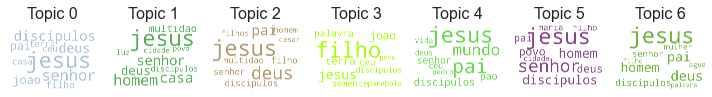

In [680]:
# Cria wordclouds
import time
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
%matplotlib inline

cols = [color for name, color in mcolors.XKCD_COLORS.items()]
cloud = WordCloud(stopwords=my_stopwords, 
        background_color='white', 
        width=2500, 
        height=1800, 
        max_words=20, 
        colormap='tab10', 
        color_func=lambda *args, **kwargs: cols[i],
        prefer_horizontal=1.0)

topics = lda_model_2.show_topics(formatted=False)

fig, axes = plt.subplots(1, 7, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=600)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

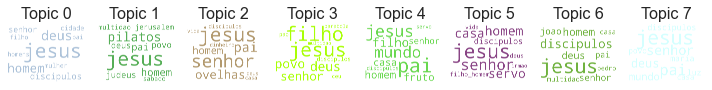

In [702]:
# Cria wordclouds
import time
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
%matplotlib inline

cols = [color for name, color in mcolors.XKCD_COLORS.items()]
cloud = WordCloud(stopwords=my_stopwords, 
        background_color='white', 
        width=2400, 
        height=1800, 
        max_words=20, 
        colormap='tab10', 
        color_func=lambda *args, **kwargs: cols[i],
        prefer_horizontal=1.0)

topics = lda_model_3.show_topics(formatted=False)

fig, axes = plt.subplots(1, 8, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=600)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()
print("\n")


<h2>Advanced exploration of LDA results</h2>

<h3>Allocation of topics in all documents</h3>

In [691]:
topics = [lda_model_3[corpus[i]] for i in range(len(data))]
print(topics)

[[(3, 0.99629104)], [(3, 0.11379834), (6, 0.8830704)], [(6, 0.9943417)], [(7, 0.9962306)], [(0, 0.087432764), (7, 0.9105779)], [(2, 0.9968988)], [(5, 0.9959479)], [(6, 0.92794216), (7, 0.06943297)], [(6, 0.9971274)], [(0, 0.9974039)], [(4, 0.99634904)], [(4, 0.99771)], [(3, 0.99815124)], [(6, 0.99675465)], [(0, 0.9971508)], [(5, 0.996148)], [(6, 0.99614716)], [(4, 0.9969921)], [(0, 0.99619)], [(2, 0.99603915)], [(1, 0.5414478), (3, 0.41391215), (4, 0.04298189)], [(0, 0.99713904)], [(7, 0.9972835)], [(3, 0.9975496)], [(2, 0.9974975)], [(6, 0.9985091)], [(1, 0.99841857)], [(0, 0.99460423)], [(6, 0.9975915)], [(6, 0.9962506)], [(5, 0.99645966)], [(3, 0.9971965)], [(6, 0.9974606)], [(6, 0.99819845)], [(0, 0.99737513)], [(3, 0.93001556), (6, 0.06675356)], [(6, 0.99769443)], [(0, 0.99781)], [(1, 0.9963864)], [(3, 0.9976485)], [(3, 0.99681413)], [(6, 0.7062925), (7, 0.2923264)], [(1, 0.9975755)], [(6, 0.9940536)], [(7, 0.9985219)], [(0, 0.99792683)], [(3, 0.99787015)], [(1, 0.99753225)], [(6,

In [689]:
def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res

topics_document_to_dataframe([())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0385366,NaN,NaN,NaN,NaN,NaN,0.0913012,NaN,NaN,0.869287,NaN


In [686]:
# Like TF-IDF, create a matrix of topic weighting, with documents as rows and topics as columns
document_topic = \
pd.concat([topics_document_to_dataframe(topics_document, num_topics=num_topics) for topics_document in topics]) \
  .reset_index(drop=True).fillna(0)

NameError: name 'topics_document_to_dataframe' is not defined

In [ ]:
# Which document are about topic 7
document_topic.sort_values(7, ascending=False)[14].head(20)

# Cria wordclouds com o LSI - LSA MODEL

In [310]:
''' 
# Cria wordclouds com o LSI - LSA MODEL
import time
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
%matplotlib inline

cols = [color for name, color in mcolors.XKCD_COLORS.items()]
cloud_2= WordCloud(stopwords=my_stopwords, 
        background_color='white', 
        width=2500, 
        height=1800, 
        max_words=20, 
        colormap='tab10', 
        color_func=lambda *args, **kwargs: cols[i],
        prefer_horizontal=1.0)

topics_2 = lsi_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 7, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words_2 = dict(topics_2[i][1])
    cloud_2.generate_from_frequencies(topic_words, max_font_size=500)
    plt.gca().imshow(cloud_2)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=15))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()
'''

" \n# Cria wordclouds com o LSI - LSA MODEL\nimport time\nfrom PIL import Image\nimport matplotlib.pyplot as plt\nimport matplotlib.colors as mcolors\nfrom wordcloud import WordCloud, ImageColorGenerator, STOPWORDS\n%matplotlib inline\n\ncols = [color for name, color in mcolors.XKCD_COLORS.items()]\ncloud_2= WordCloud(stopwords=my_stopwords, \n        background_color='white', \n        width=2500, \n        height=1800, \n        max_words=20, \n        colormap='tab10', \n        color_func=lambda *args, **kwargs: cols[i],\n        prefer_horizontal=1.0)\n\ntopics_2 = lsi_model.show_topics(formatted=False)\n\nfig, axes = plt.subplots(1, 7, figsize=(10, 10), sharex=True, sharey=True)\n\nfor i, ax in enumerate(axes.flatten()):\n    fig.add_subplot(ax)\n    topic_words_2 = dict(topics_2[i][1])\n    cloud_2.generate_from_frequencies(topic_words, max_font_size=500)\n    plt.gca().imshow(cloud_2)\n    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=15))\n    plt.gca().axis('off')

<p><h2>Tecnicamente acabou nas Worldclouds dentro das Clusters<br> 
Abaixo seria uma tentativa de se usar outros métodos com o NMF e o LDA usando SCIKIT LEARN</h2></p>

Docs:https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html#sklearn.decomposition.LatentDirichletAllocation

Examples: https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py


In [298]:
import time
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from pprint import pprint

n_samples = 89           #number of docs
n_features = 500000      #number of general words
n_components = 10        #number of topics
n_top_words = 30         #number of topic words
doc_topic_prior=0.6      #alpha prior of documents if None = 1/ n_components for defaults
topic_word_prior=0.3     #beta or eta of topics if None = 1/ n_components for defaults
evaluate_every=-1        # This parameter is None, beacuse the model is not update
verbose=0
random_state=123456 #processamento online


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
    
  

In [299]:
# We use a few heuristics
# to filer out useless terms early on: the posts are stripped of headers,
# footers and quoted replies, and common English words, words occurring in
# only one document or in at least 95% of the documents are removed.
import time
from time import time
import pickle

print("Loading dataset...")

#print(len(data_clean['text']))

'''
data_samples = data_clean(shuffle=True, random_state=1, \
                         remove=('tokens_sentences','sentences','tokens_sentences_lemmatized',
                         'tokens_sentences_stemmed'),
                          return_X_y=True)
data_samples=data_clean[:n_samples]                         
print("done in %0.3fs.")



t0 = time()
data, _ = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'),
                             return_X_y=True)
'''

t0 = time()
data_samples= data_clean['text']     #carregar base de dados
#data_samples = data_clean[:n_samples]
print("done in %0.3fs." % (time() - t0))



Loading dataset...
done in 0.010s.


In [300]:
# Use tf-idf features for NMF.
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
print("Extracting tf-idf features for NMF...")

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words=my_stopwords)
doc_term_matrix = tfidf_vectorizer.fit_transform(data_samples.values.astype('U'))

t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print(tfidf)
print("done in %0.3fs." % (time() - t0))

Extracting tf-idf features for NMF...
  (0, 1974)	0.06633944888280803
  (0, 2151)	0.057200443605646634
  (0, 1739)	0.06119262801877487
  (0, 567)	0.06119262801877487
  (0, 819)	0.021392654346365725
  (0, 2395)	0.051180734720588365
  (0, 437)	0.07874030633057146
  (0, 1156)	0.052506574923355594
  (0, 2697)	0.07874030633057146
  (0, 2060)	0.03754554957415295
  (0, 868)	0.059085412299077766
  (0, 684)	0.06633944888280803
  (0, 1822)	0.047707156344689625
  (0, 1985)	0.02913687653951776
  (0, 2299)	0.07874030633057146
  (0, 716)	0.06119262801877487
  (0, 1517)	0.12031715242677653
  (0, 2048)	0.07874030633057146
  (0, 1668)	0.0635815921683518
  (0, 1047)	0.1392026021068201
  (0, 2477)	0.07874030633057146
  (0, 2428)	0.07359348546653828
  (0, 2355)	0.06871632434748834
  (0, 184)	0.11817082459815553
  (0, 199)	0.07874030633057146
  :	:
  (88, 2730)	0.10338122494169717
  (88, 276)	0.16119668074676738
  (88, 2739)	0.046877952609104684
  (88, 1842)	0.33302586149809255
  (88, 2401)	0.2710246860795

In [301]:
# Fit the NMF model
from time import time
print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
                            
t0 = time()
nmf = NMF(n_components=n_components, random_state=42,alpha=.1, l1_ratio=.5, beta_loss='frobenius', \
          tol=0.0001, max_iter=5,verbose=0).fit(tfidf)
print("done in %0.3fs." % (time() - t0))


print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=89 and n_features=500000...
done in 0.144s.

Topics in NMF model (Frobenius norm):
Topic #0: deus homem senhor filho joao discipulos povo casa multidao mulher espirito reino pai mae cidade jerusalem vinha homens menino vida filhos galileia servo veio mestre lei terra irmao templo dias
Topic #1: pilatos judeus rei barrabas chefes cruz sacerdotes soldados crucificao jose sepulcro crucificado corpo entregou chamado maria crucificaram preparacao salvese vara centuriao cabeca pediu colocaram herodes purpura governador eloi homem discipulo
Topic #2: pai mundo vou vida creiam enviaste ama ovelhas obras alegria pecado conhecem abraao vim ve judeus palavras conselheiro palavra fruto ti dou creem amor gloria cre pedirem deus eterna respeito
Topic #3: pedro pao simao barco peixes rede discipulos discipulo sabes iria lavar senhor judas amo paes praia mar comer ama pes amava vivo joao cuide vida capa carne permaneca importa quis

C:\Users\Klemer\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 5 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [302]:
# Fit the NMF model
print("Fitting the NMF model (generalized Kullback-Leibler divergence) with "
      "tf-idf features, n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=123456,
          beta_loss='kullback-leibler', solver='mu', max_iter=5, alpha=.1,
          l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))


print("\nTopics in NMF model (generalized Kullback-Leibler divergence):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)


Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=89 and n_features=500000...
done in 0.283s.

Topics in NMF model (generalized Kullback-Leibler divergence):
Topic #0: deus homem filho senhor discipulos mulher homens joao povo multidao jerusalem pai mae espirito veio moises fariseus lei reino ceus filhos cidade casa terra mortos elias chamou rei menino mestre
Topic #1: pilatos judeus chefes sacerdotes rei soldados guardas herodes barrabas sumo sepulcro jose cruz sacerdote corpo chamado crucificao crucificado maria governador cristo escritura povo crucificaram salve festa colocaram pediu entregou caifas
Topic #2: pai mundo vida judeus vou luz vim obras deus ovelhas abraao cre ve alegria conhecem pecado creiam gloria eterna enviaste palavra ama palavras fruto testemunho respeito dou odeia filho lazaro
Topic #3: pedro pao discipulos barco paes simao judas peixes comer gracas joao sinal herodes cestos mar quantos pedacos comeram multidao fermen

In [303]:
# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features= n_features,
                                stop_words= my_stopwords)
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
print()

print("Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_components=n_components, 
                                doc_topic_prior=doc_topic_prior, 
                                topic_word_prior=topic_word_prior,
                                max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                evaluate_every=-1,
                                verbose=0,
                                random_state=random_state, 
                                learning_decay=0.5
                                )
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Extracting tf features for LDA...


C:\Users\Klemer\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['prostrou'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


done in 0.443s.

Fitting LDA models with tf features, n_samples=89 and n_features=500000...
done in 3.948s.

Topics in LDA model:
Topic #0: pai deus filho senhor discipulos casa homem abraao reino importante ceus mundo fariseus hipocritas coracao terra lei vida corpo homens porta vou olhos servo comer testemunho melhor profetas jurar roupas
Topic #1: pai senhor deus homem joao filho discipulos pilatos povo lei vida cidade ovelhas espirito chamado ceus jerusalem reino terra casa multidao irmao rei dias pedro judeus palavra galileia fruto mundo
Topic #2: homem senhor deus filho olho irmao bemaventurados casa discipulos sabado reino coracao terra tirar cisco mao joao arvore fome pecadores lei viga permitido amem fariseus veio chamado pai amam profetas
Topic #3: homem deus pilatos filho casa judeus reino pai joao vida rei sacerdotes mulher senhor sepulcro povo ceu olhos galileia corpo respeito ceus multidao lei pes herodes maria servo roupas terra
Topic #4: discipulos homem pedro pai sacer

In [ ]:
#Test with Stemming - Teste com o Stemming - ELE REMOVE TODOS OS RADICAIS TRABALHOS FUTUROS. ENCONTRAR A SEMANTICA COM ELES

In [694]:
import nltk
nltk.download('rslp')

[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\Klemer\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

<h2>**TEST Stemming** -- Reduce some words to a stem </h2>
Fonte: https://stackoverflow.com/questions/32215827/simple-python-implementation-of-collaborative-topic-modeling/40954714#40954714

In [417]:
import gensim
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import RSLPStemmer
from gensim import corpora, models
from pprint import pprint

stopwords = stopwords.words('portuguese')
st = RSLPStemmer()
texts = []

#doc1 = "Veganism is both the practice of abstaining from the use of animal products, particularly in diet, and an associated philosophy that rejects the commodity status of animals"
#doc2 = "A follower of either the diet or the philosophy is known as a vegan."
#doc3 = "Distinctions are sometimes made between several categories of veganism."
#doc4 = "Dietary vegans refrain from ingesting animal products. This means avoiding not only meat but also egg and dairy products and other animal-derived foodstuffs."
#doc5 = "Some dietary vegans choose to wear clothing that includes animal products (for example, leather or wool)." 

docs = data_clean['text'] #substitui pelos dados

for i in docs:

    tokens = word_tokenize(i.lower())
    stopped_tokens = [w for w in tokens if not w in my_stopwords]
    stemmed_tokens = [st.stem(i) for i in stopped_tokens]
    texts.append(stemmed_tokens)

    
#Corpus
dictionary_stem = corpora.Dictionary(texts)
corpus_lda_stem = [dictionary_stem.doc2bow(text) for text in texts]

# generate LDA model using gensim  
lda_model_stem = gensim.models.ldamodel.LdaModel(corpus, num_topics=10, chunksize=89, id2word = dictionary, passes=5, alpha=0.7,eta=0.1,eval_every=-1, random_state=42)

top_topics_stem = lda_model_stem.top_topics(corpus_lda_stem)

for i,top_topics_stem in lda_model_stem.show_topics(formatted=True, num_topics=10, num_words=20):
    pprint(str(i)+": "+ top_topics_stem)
    print()

#print(ldamodel.print_topics(num_topics=10, num_words=20))

('0: 0.016*"jesu" + 0.013*"hom" + 0.011*"rein" + 0.011*"ouv" + 0.009*"seme" + '
 '0.009*"parabol" + 0.009*"cas" + 0.009*"palavr" + 0.009*"filh" + 0.008*"olh" '
 '+ 0.008*"ceu" + 0.007*"tir" + 0.007*"discipul" + 0.007*"sement" + '
 '0.007*"terr" + 0.007*"deu" + 0.007*"senh" + 0.006*"frut" + 0.006*"ped" + '
 '0.006*"profet"')

('1: 0.016*"senh" + 0.011*"mestr" + 0.011*"jur" + 0.011*"serv" + 0.010*"faris" '
 '+ 0.010*"lei" + 0.009*"hom" + 0.008*"talent" + 0.008*"banquet" + '
 '0.008*"filh" + 0.008*"deu" + 0.007*"jesu" + 0.006*"hipocrit" + 0.006*"cas" + '
 '0.006*"cham" + 0.006*"just" + 0.006*"receb" + 0.006*"ceu" + 0.006*"envi" + '
 '0.005*"profet"')

('2: 0.023*"hom" + 0.022*"deu" + 0.020*"jesu" + 0.014*"filh" + 0.010*"espirit" '
 '+ 0.008*"sab" + 0.008*"faris" + 0.007*"cas" + 0.007*"discipul" + '
 '0.007*"rein" + 0.007*"fal" + 0.006*"terr" + 0.006*"jus" + 0.006*"mae" + '
 '0.006*"ceu" + 0.006*"palavr" + 0.006*"joa" + 0.005*"conden" + 0.005*"juiz" + '
 '0.005*"testemunh"')

('3: 0.051*"j

<h2>Apendice</h2>


Rerefences: #https://github.com/FelixChop/MediumArticles/blob/master/LDA-BBC.ipynb - And others below


## 1 https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0 
##Auctor: Shashank Kapadia -- 2019  (Testa esse aqui tbm)

## 2 https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html -- doc

##3 https://sigmoidal.ai/como-criar-uma-wordcloud-em-python/  -- WorldClouds ## 
##4 http://tirandolicoesdetudo.com.br/criando-uma-nuvem-de-palavras-wordcloud-com-dados-do-meu-cv/ -- WorldCloud ##

##5 https://www.youtube.com/watch?v=iQ1bfDMCv_c&list=PLf6b7z7NwdGVMXPEvoJu64jxtE58q4CH8&index=3&t=9s - Videos da ALICE ZHAO##
#https://github.com/adashofdata/nlp-in-python-tutorial - 2018


## 6 https://gist.github.com/alopes/5358189 - lista de StopWords em português com correspondências. 


## 7 https://medium.com/@viniljf/utilizando-processamento-de-linguagem-natural-para-criar-um-sumariza%C3%A7%C3%A3o-autom%C3%A1tica-de-textos-775cb428c84e

##8 - https://medium.com/somos-tera/como-modelar-t%C3%B3picos-atrav%C3%A9s-de-latent-dirichlet-allocation-lda-atrav%C3%A9s-da-biblioteca-gensim-1fa17357ad4b -- 2020

# 9 https://www.kdnuggets.com/2019/09/overview-topics-extraction-python-latent-dirichlet-allocation.html 
